The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
4
[(10, 62), (28, 42), (4, 77), (18, 62), (9, 16), (32, 94), (6, 72), (4, 16), (1, 64), (20, 22), (2, 86), (9, 30), (67, 86), (67, 74), (51, 76), (56, 91), (73, 78), (59, 84), (79, 96), (2, 67)]



.........................initialize..........................
Device: cuda:0
FileName: AA/AA_RGG_identical_12_4_-1_0_100_10.0_150000
Strains: 4
Using RGG random graph model
Num of nodes: 100
Num of links: 400
Reverse ZERO: tensor(4.8708e-07, device='cuda:0')
Num links weight bigger than 0.2: tensor(0, device='cuda:0')
Num links weight bigger than 0.1: tensor(0, device='cuda:0')
Num links weight bigger than 0.01: tensor(406, device='cuda:0')
.............................................................
400


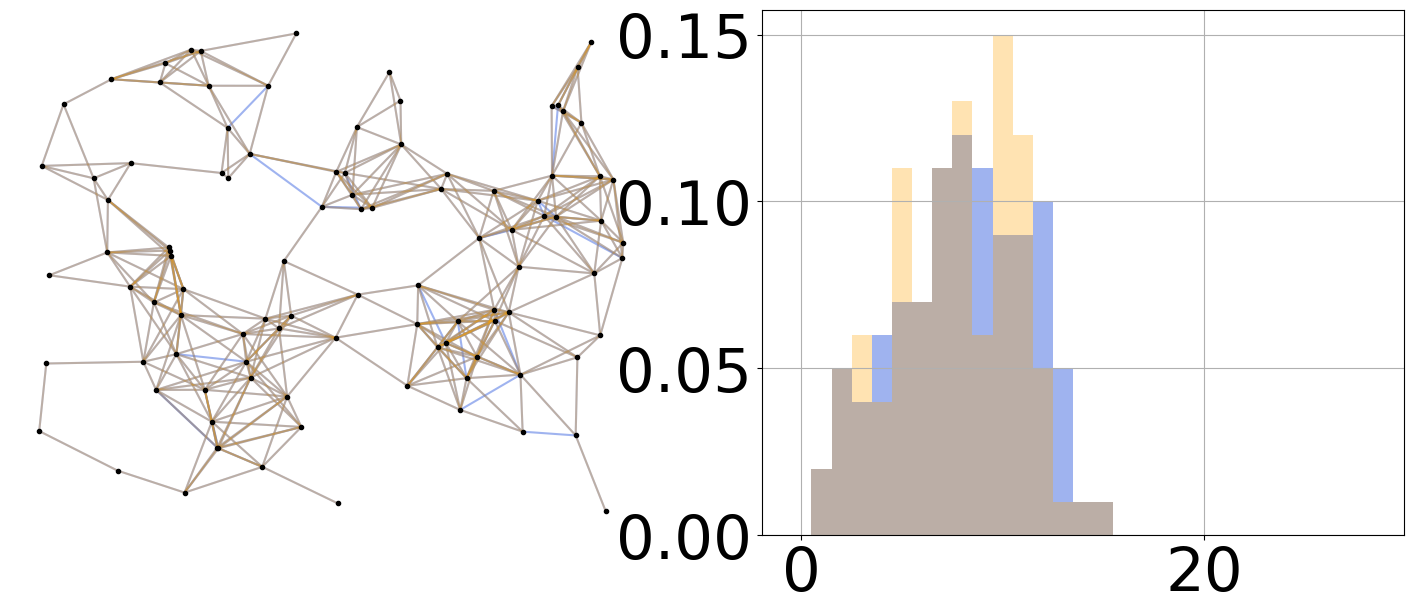

In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import argparse
import modules.random_graph as random_graph
import logging
import modules.weight as weight
import modules.A_mat as A_mat
import modules.pramameters as pramameters
import modules.population as population
import modules.plotGraph as plotGraph
import modules.simulation as simulation
import modules.utils as utils
import modules.nn as mynn
import modules.evaluate as evaluate
import modules.transfer as transfer
import math


#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
#preset
paras.modelLoad= "AA"

#realGraphs= ["contious_Africa", "contious_china", "contious_EU", "contious_usa", "mobility_german", "mobility_us"]
realGraphs2= ["global_air", "us_air"]
realGraphs3= ["us_air100", "us_air200", "us_air300", "us_air400", "spain_bus", "spain_car", "spain_plane", "spain_train"]
paras.randomGraph= "RGG"
paras.weightModel= "identical"
paras.epoches= 150000
paras.intense= -1
paras.seed= 12
paras.plot= "spring"
if paras.randomGraph== "RGG":
    paras.plot= "2d_RGG"
paras.strains= 4
paras.dense= 0
paras.identicalf= 0.01
paras.n= 100


random.seed(paras.seed)

#results and logs file name
fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.randomGraph}_{paras.weightModel}_{paras.seed}_{paras.strains}\
_{paras.intense}_{paras.dense}_{paras.n}_{paras.identicalf*1000}_{paras.epoches}"

printFlag= 1
if printFlag!=1:
    logging.basicConfig(filename="logs/"+paras.modelLoad+".out", level=logging.INFO)

plotFlag= 1

device= paras.device if torch.cuda.is_available() else "cpu"

P= population.population(paras.n, device= device)

if paras.dense<=0:
    paras.dense= int(math.log(paras.n))-paras.dense
    utils.log_print(printFlag, paras.dense)

# generate random graphs: RGG(defult), ER, WS, BA'
if paras.randomGraph=="RGG":
    A, G, pos= random_graph.get_RGG_random_contact(paras.n, paras.dense, device= device)
elif paras.randomGraph=="BA":
    A, G= random_graph.get_BA_random_contact(paras.n, paras.dense, device= device)
elif paras.randomGraph=="WS":
    A, G= random_graph.get_WS_random_contact(paras.n, paras.dense*2, paras.wsProbability, device= device)
elif paras.randomGraph=="ER":
    A, G= random_graph.get_ER_random_contact(paras.n, paras.dense, device= device)
else:
    A, G= random_graph.read_from_file("graphs/"+paras.randomGraph+".npy")
    paras.n= A.shape[0]
    if A.diagonal().sum()> paras.n+1:
        Pop= A.sum(axis=0)+A.sum(axis=1)-A.diagonal()+1e-5
        A= A/Pop
        A= A.fill_diagonal_(0)
        P= torch.tensor(Pop, device= device)
        G = nx.from_numpy_array((A>0.002).numpy())
    else:
        P= population.population(paras.n, device= device)

#assign adjacency weight to matrix: degree(defult), gravity

if paras.weightModel=="degree":
    Aw= weight.degree_model(A, P= P, device=device)
elif  paras.weightModel=="gravity":
    Aw= weight.gravity_model(G, pos, P, device= device)
elif  paras.weightModel=="identical":
    Aw= weight.identical_model(A, paras.identicalf, device= device)
elif  paras.weightModel=="none":
    Aw= A.to(device= device)

npzfile = np.load("results/"+fileName+".npz")
PreA= torch.tensor(npzfile["Apre"]).to(device= device)
Aw= torch.tensor(npzfile["A"]).to(device= device)
G= nx.from_numpy_array((Aw>0.001).cpu().numpy())
sortGp, _= torch.sort(PreA.flatten())
Gp= nx.from_numpy_array((PreA>=sortGp[-G.number_of_edges()-100]).cpu().numpy())
Awf, originalNodes, seleLinksT, routingNodes= transfer.create_transfer_net(Aw, G, paras, mf= 20, device= device)
Gf = nx.from_numpy_array((Awf>0.001).cpu().numpy())
# Aw= Awf


utils.log_print(printFlag,"\n\n\n.........................initialize..........................")
utils.log_print(printFlag,"Device:", device)
utils.log_print(printFlag,"FileName:", fileName)
utils.log_print(printFlag,"Strains:", paras.strains)
utils.log_print(printFlag,"Using", paras.randomGraph, "random graph model")
utils.log_print(printFlag,"Num of nodes:", G.number_of_nodes())
utils.log_print(printFlag,"Num of links:", G.number_of_edges())
Zmat= A_mat.create_A_mat(Aw, P)
Zmat2= A_mat.reverse_A_mat(Zmat-torch.eye(Aw.shape[0], dtype= torch.float32, device= Aw.device), P)
utils.log_print(printFlag,"Reverse ZERO:", torch.sum(torch.abs(Zmat2-Aw)))
utils.log_print(printFlag,"Num links weight bigger than 0.2:", torch.sum(Zmat>0.2)-paras.n)
utils.log_print(printFlag,"Num links weight bigger than 0.1:", torch.sum(Zmat>0.1)-paras.n)
utils.log_print(printFlag,"Num links weight bigger than 0.01:", torch.sum(Zmat>0.01)-paras.n)
utils.log_print(printFlag,".............................................................")
#plot this network  
if plotFlag==1:
    if paras.plot== "2d_RGG":
        plotGraph.plot_spring_and_degree(G, Gf, pos= pos)
    elif paras.plot== "spring":
        plotGraph.plot_spring_and_degree(G, Gf)

[8.393186380177282, 8.603380284275516, 8.260935225760983, 8.449885762803952, 8.600104627324052, 8.456026136926209, 7.858729126950555, 8.485563154022449, 7.942120899991517, 8.285576954484876, 8.07782504269883, 7.923220611232683, 8.140098841680611, 8.117726674226638, 8.565248446631092, 8.611284158267036, 8.689423740092192, 8.419551564467445, 8.141357643793134, 8.364412371269136, 8.46622564906106, 8.079049756021277, 8.790815729665278, 8.38689363771575, 8.162674747020509, 8.421053699979044, 8.135707733853447, 8.706788773816541, 8.743514708447986, 7.871172082223079, 8.689343456960916, 8.420534527056931, 8.658373470142049, 8.136309271547054, 8.442316932955764, 8.128597222622798, 8.634953149196251, 8.665558752791783, 8.285494643371925, 8.110848967519384]
[7.517414300033676, 7.525843508849428, 7.4673459670298525, 7.566087404364242, 7.47815146161195, 7.467465329099815, 7.559372502215545, 7.597516260090809, 7.42449137706087, 7.427339831991647, 7.43949767534216, 7.487185415224729, 7.4810658048947

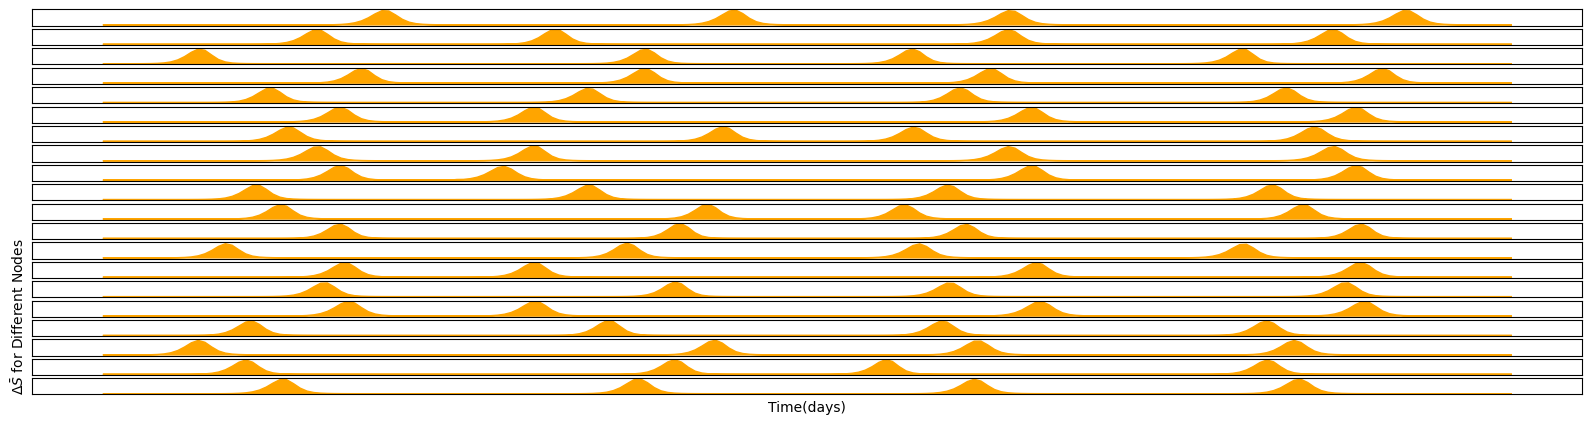

In [8]:
R0s_taus= [[random.uniform(paras.R0Mean-paras.R0Std, paras.R0Mean+paras.R0Std), 
            random.uniform(paras.tauMean-paras.tauStd, paras.tauMean+paras.tauStd)] for _ in range(40)]
paras.R0s=  [ R0s_taus[i][0] for i in range(40)]
paras.taus= [ R0s_taus[i][1] for i in range(40)]
utils.log_print(printFlag,paras.R0s)
utils.log_print(printFlag,paras.taus)
deltaSsTensor, randomList, _= simulation.multi_strains(G, paras, Zmat, intense= paras.intense, lower= 20, device= device)
deltaSs= deltaSsTensor.sum(dim= -1, keepdim= True)
propition= deltaSsTensor/(deltaSs+1e-8)
deltaSs= deltaSs.squeeze()#(1, 2, 20), dim of nodes, dim of heads, dim of signal
divide= deltaSsTensor.transpose(1, 2)#-divideCp[:,:, 0:deltaSsTensor.shape[1]]


utils.log_print(printFlag,divide.shape)
if plotFlag==1:
    numPlot= 20
    fig, axs = plt.subplots(numPlot, 1, figsize=(20, 5))
    
    for i, ax in enumerate(axs):
        ax.fill(divide[i, :].T.cpu().detach().T.reshape(-1),  color='orange')
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_ylabel(f"{i}")
    plt.ylabel(r"$\Delta \bar S$ for Different Nodes",  loc='bottom')
    plt.xlabel("Time(days)")
    
    
    #plt.title(f"Example of {numPlot} nodes epidemic newly infected.")
print(divide[i, :].shape)

torch.Size([100, 4, 52])


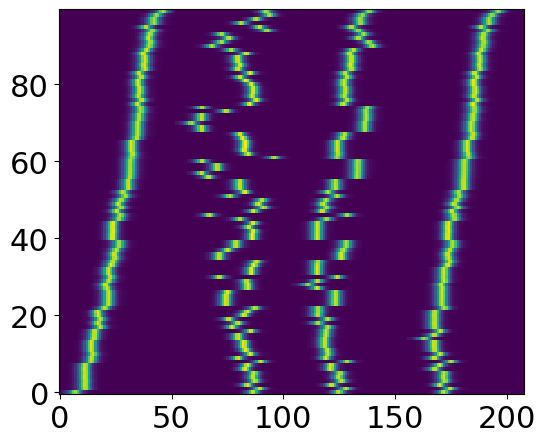

In [9]:
def rank_nodes_by_distance(G, source_node):
    # Get distances from the source_node to all other nodes
    distances = nx.single_source_shortest_path_length(G, source_node)
    # Sort nodes by distance from the source_node
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1])
    # Return sorted nodes by their distance (excluding the distance values)
    return [node for node, _ in sorted_nodes]

print(divide.shape)
nodes_diantance_index= rank_nodes_by_distance(G, randomList[0])

shapeY= divide.shape[0]
shapeX= divide.shape[1]*divide.shape[2]
divide2D= divide.reshape(shapeY, shapeX).cpu().detach()
heatMapDivide2D= divide2D[nodes_diantance_index, :]
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fontsize= 22
cmap= ax.pcolormesh(range(shapeX), range(shapeY), heatMapDivide2D)
#cbar= fig.colorbar(cmap)

#cbar.ax.tick_params(labelsize= fontsize-7)

# plt.ylabel("Nodes Index",  loc='bottom', fontsize= fontsize)

# plt.xlabel(f"{paras.modelLoad}", fontsize= fontsize)

plt.gca().axes.get_xaxis().set_visible(True)

plt.gca().axes.get_yaxis().set_visible(True)


plt.tick_params(axis='both', labelsize=fontsize)

plt.show()

In [10]:
paras.seed= 1025
torch.manual_seed(paras.seed)
timeHorizon= divide.shape[2]-1
if   paras.modelLoad=="AA":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AsA":
    myMatch= mynn.matchingAs(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AB":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BA":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BB":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="infer2018":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)

    
optimizer1 = torch.optim.Adam(myMatch.parameters(),lr=3e-4)#myMatch.parameters()
optimizer2 = torch.optim.Adam({myEpi.taus},lr=3e-4)
optimizer3 = torch.optim.Adam({myEpi.R0dTaus},lr=3e-4)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []
predError= []
if paras.modelLoad in ["infer2018", "AB", "BB"]:
    threshold_value= 0.1
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.taus.register_hook(hook)
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.R0dTaus.register_hook(hook)

def evaluate_epoch(preZ, methods= []):
    IMatrix= torch.eye(paras.n, device= device)
    preA= A_mat.reverse_A_mat(preZ-IMatrix, P)
    oneResult= []
    for method in methods:
        oneResult.append(method(Aw.cpu(), preA.cpu()))
    return oneResult
evaluateResults= []
PreZs= []
Zmatg= A_mat.create_A_mat(Awf, P)

tensor(2.6049, device='cuda:0')


In [11]:
evaluateMeth= [evaluate.spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity,evaluate.ROC_AUC, evaluate.PR_AUC]

if paras.modelLoad== "infer2018":
    for j in tqdm(range(paras.epoches)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        inferZmat= myMatch(divide, paras.modelLoad)
        inferZmat= inferZmat*0.1
        predSignal, signal, PreZ= myEpi(divide, inferZmat)
        tempEye= torch.eye(paras.n, device= device)

        loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()+1e-5*torch.sum(torch.log(torch.sum(PreZ-tempEye, dim= 1)))
        losses.append((loss-1e-5*torch.sum(torch.log(torch.sum(PreZ-tempEye, dim= 1)))).item())
        if torch.isnan(loss).any():
            utils.log_print(printFlag, f"meet nan value at {j}")#
            break
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
        if j%paras.evaluateEvery== 0:
            evaluateResults.append(evaluate_epoch(PreZ.detach(), evaluateMeth))
else:
    for j in tqdm(range(paras.epoches*12)):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        inferZmat= myMatch(divide, paras.modelLoad)
        predSignal, signal, PreZ= myEpi(divide, inferZmat)
        loss= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])*10+ torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()+ 0.1*transfer.relative_entropy(PreZ, Zmatg)
        if torch.isnan(loss).any():
            utils.log_print(printFlag, f"meet nan value at {j}")#
            break
        error= myloss(predSignal[:, :, 0:-1], signal[:, :, 1:])
        errorTmp= myloss(predSignal[:, :, 0:-1] ,signal[:, :, 1:])
        if errorTmp.item()<3e-7:
            print("Meet with 1e-7")
            break
        predError.append(errorTmp.item())
        losses.append(error.item())
        loss.backward(retain_graph=True)
        optimizer1.step()
        optimizer2.step()
        optimizer3.step()
        if j%paras.evaluateEvery== 0:
            evaluateResults.append(evaluate_epoch(PreZ.detach(), evaluateMeth))
            # PreZs.append(inferZmat.detach().clone())

  0%|          | 184/1800000 [00:04<10:53:19, 45.91it/s]


KeyboardInterrupt: 

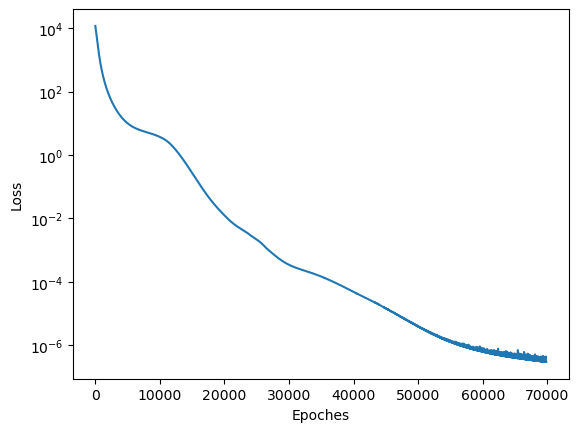

In [61]:
if plotFlag==1:
    plt.plot(predError)
    plt.yscale("log") 
    plt.ylabel("Loss") 
    plt.xlabel("Epoches") 

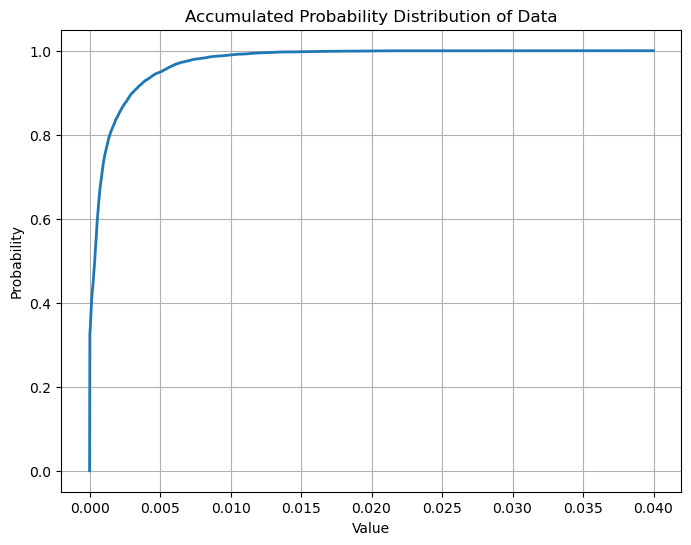

In [62]:
inferZmatNp= inferZmat.cpu().detach().numpy().squeeze()
pxs= []
pys= []
# Compute histogram
for i in range(2000):
    px= i/1000/50
    py= np.sum(inferZmatNp<px)/10000
    pxs.append(px)
    pys.append(py)
    pass

# Plot the histogram as a probability distribution
plt.figure(figsize=(8, 6))
plt.plot(pxs, pys, linestyle='-', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Accumulated Probability Distribution of Data')
plt.grid(True)
plt.show()

In [63]:

#save: A, preA, losses, taus, pretaus, R0s, preR0s, [errors]
utils.log_print(printFlag,paras.taus[0: paras.strains])
utils.log_print(printFlag,paras.R0s[0: paras.strains])
utils.log_print(printFlag,(1+myEpi.taus[0]))
utils.log_print(printFlag,((1+myEpi.taus[0])*myEpi.R0dTaus)[0])

IMatrix= torch.eye(paras.n, device= device)
PreA= A_mat.reverse_A_mat(PreZ-IMatrix, P)


evaluateResults.append(evaluate_epoch(PreZ.squeeze().detach(), evaluateMeth))


utils.log_print(printFlag,"spectral_similarity:", evaluateResults[-1][0])
utils.log_print(printFlag,"pearson_correlation:", evaluateResults[-1][1])
utils.log_print(printFlag,"jaccard_similarity:", evaluateResults[-1][2])
utils.log_print(printFlag,"ROC_AUC:", evaluateResults[-1][3])
utils.log_print(printFlag,"PR_AUC:", evaluateResults[-1][4])
utils.log_print(printFlag,torch.var(myEpi.taus, dim= 0))
utils.log_print(printFlag,torch.var(myEpi.R0dTaus, dim= 0))
startV= 5
deltaV= 7
utils.log_print(printFlag,PreA[startV:startV+deltaV, startV:startV+deltaV])
utils.log_print(printFlag,Aw[startV:startV+deltaV, startV:startV+deltaV])
fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.randomGraph}_{paras.weightModel}_{paras.seed}_{paras.strains}\
_{paras.intense}_{paras.dense}_{paras.n}_{paras.identicalf*10000}_{paras.epoches}"
np.savez("results/"+fileName+".npz", A= Aw.cpu().detach(), Apre= PreA.cpu().detach(), 
         cosine_similarity= evaluate.cosine_similarity(Aw, PreA).item(),
         loss= losses, taus= paras.taus, r0s= paras.R0s, tausP= myEpi.taus.cpu().detach(), 
         r0sP= (myEpi.R0dTaus*myEpi.taus).cpu().detach(), signal= signal.cpu().detach(), predSignal= predSignal.cpu().detach(),
           evaluates= evaluateResults)


[7.562148522854822]
[7.986633476379129]
tensor([7.3661], device='cuda:0', grad_fn=<AddBackward0>)
tensor([7.8118], device='cuda:0', grad_fn=<SelectBackward0>)
spectral_similarity: tensor(0.6020)
pearson_correlation: tensor(0.4505)
jaccard_similarity: tensor(0.2057)
ROC_AUC: 0.8081032967032966
PR_AUC: 0.005
tensor([2.5903e-09], device='cuda:0', grad_fn=<VarBackward0>)
tensor([6.2881e-08], device='cuda:0', grad_fn=<VarBackward0>)
tensor([[0.0000e+00, 5.4280e-07, 3.9197e-04, 1.7381e-03, 3.5745e-03, 6.1460e-04,
         3.4765e-07],
        [3.3190e-04, 0.0000e+00, 3.1976e-03, 2.7278e-04, 6.9176e-04, 2.7029e-04,
         1.3265e-03],
        [3.8333e-07, 7.7032e-07, 0.0000e+00, 4.4346e-07, 3.5658e-07, 3.1636e-07,
         7.1634e-07],
        [4.4305e-04, 5.1380e-07, 7.7157e-04, 0.0000e+00, 2.9859e-05, 7.4752e-04,
         3.4638e-07],
        [1.4384e-03, 4.9627e-07, 3.5236e-04, 6.5234e-04, 0.0000e+00, 5.5981e-04,
         5.1940e-07],
        [2.3219e-04, 5.2009e-07, 7.2008e-04, 4.1092e-

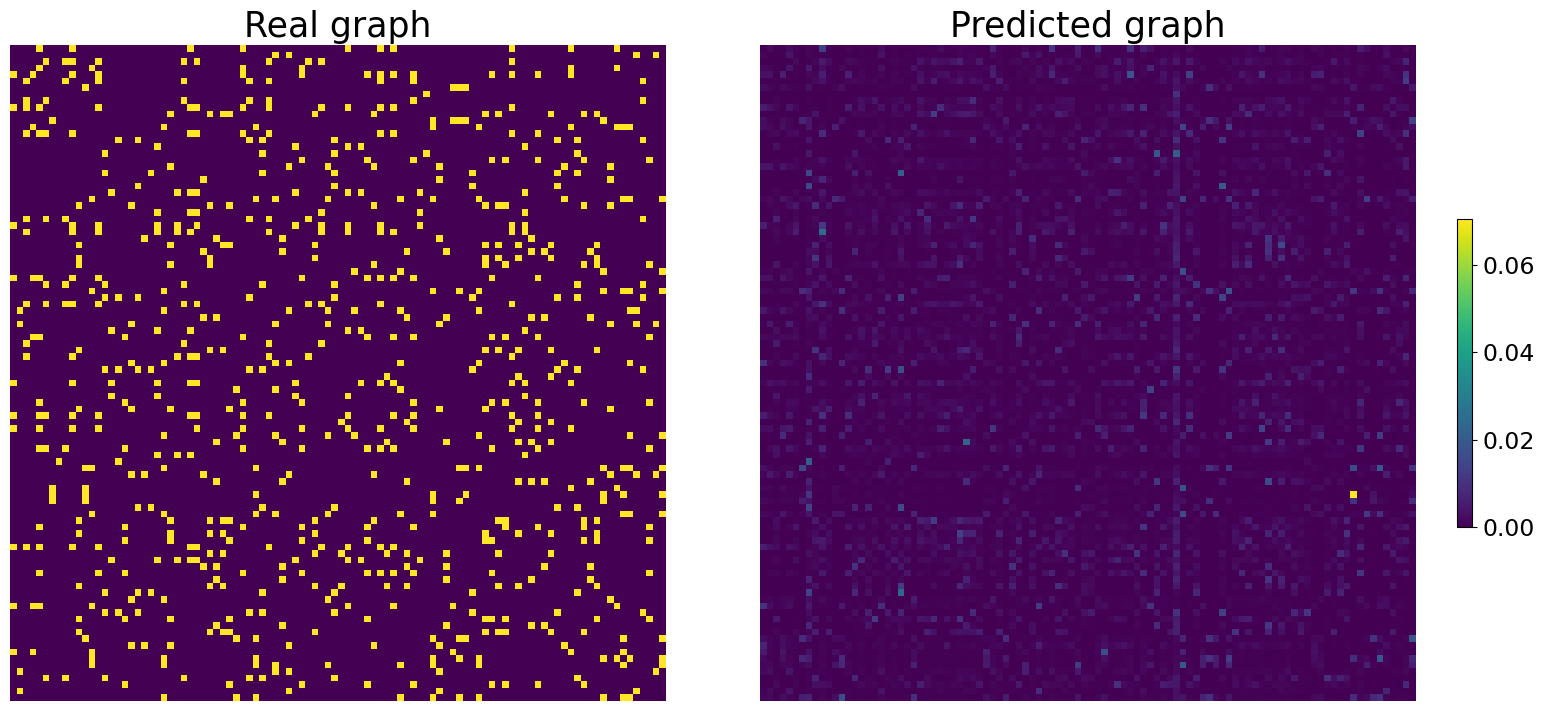

In [64]:
if plotFlag==1:
    plotGraph.plot_adjacenty(A.cpu().detach().numpy(), [ PreA.cpu().detach().numpy()])

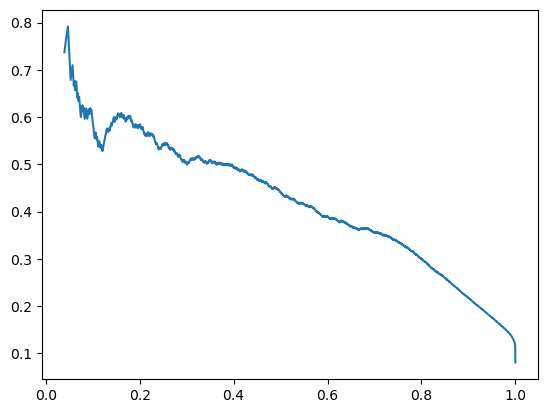

In [65]:
portions= []
xs= []
ATrueNp= A.cpu().detach().numpy()
rankedATrue= np.sort(ATrueNp.flatten())
ATrueNpBi= (ATrueNp>1e-9)*1.0
APreNp= PreA.cpu().detach().numpy()
# APreNp= sumPreA.cpu().detach().numpy()
rankedAPre= np.sort(APreNp.flatten())
for TopNum in range(20, paras.n**2):
    xs.append(((APreNp>rankedAPre[-TopNum])*APreNp).sum()/APreNp.sum())
    APreNpBi=  (APreNp>rankedAPre[-TopNum])*1.0
    portions.append(((ATrueNpBi*APreNpBi).sum())/APreNpBi.sum())
plt.plot(xs, portions)

torch.Size([100, 1, 56])


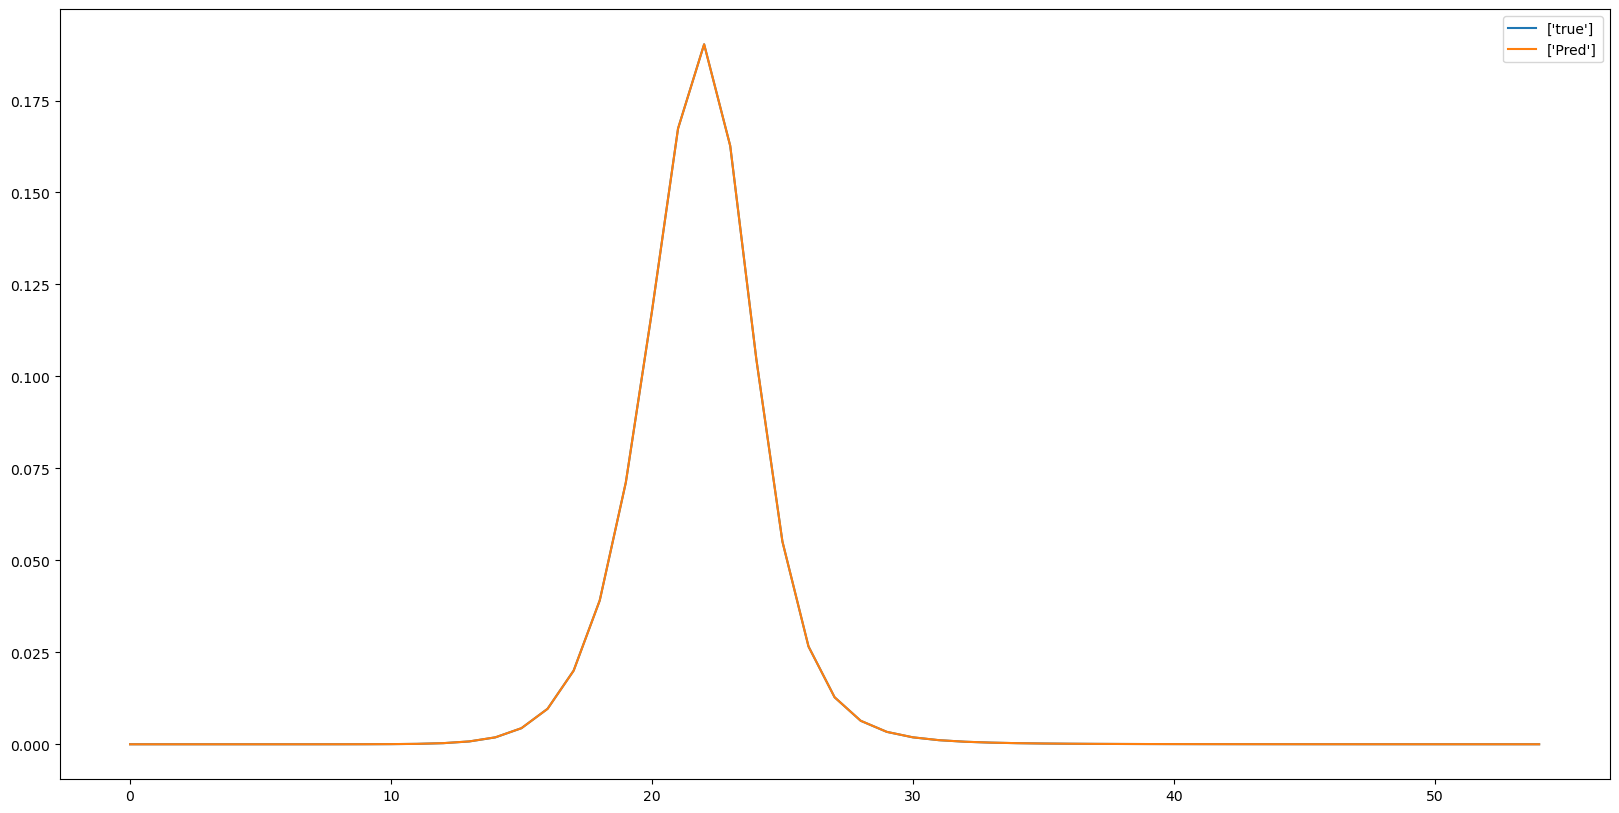

In [66]:
if plotFlag==1:
    node= 1
    plt.figure(figsize=(20, 10))
    plt.plot(signal[node, :, 1:].squeeze().T.cpu().detach(), label=paras.strains*["true"])
    plt.plot(predSignal[node, :, 0:-1].squeeze().T.cpu().detach(), label=paras.strains*["Pred"])
    plt.legend()
    print(signal.shape)

In [ ]:
seeds= [1000, 1001, 1003, 1006, 1007, 1008, 1009, 1013, 1014, 1015, 1016, 1017, 1018, 1020, 1021, 1022, 1025]
preAs= []
sumPreA= 0
paras.dense= 4
countTmp= 0
Pearsons= []
for seed in seeds2:
    countTmp+= 1
    fileName= fileName= f"{paras.modelLoad}/{paras.modelLoad}_{paras.randomGraph}_{paras.weightModel}_{seed}_{paras.strains}_{paras.intense}_{paras.dense}_{paras.n}_{paras.identicalf*10000}_{paras.epoches}"
    npzfile = np.load("results/"+fileName+".npz")
    PreA= torch.tensor(npzfile["Apre"]).to(device= device)
    AdjCurTen= torch.tensor(npzfile["A"]).to(device= device)
    sumPreA+= PreA
    sumPreATmp= sumPreA/countTmp
    Pearsons.append(np.round(evaluate.pearson_correlation(sumPreATmp, AdjCurTen).item(),3))
    signal= torch.tensor(npzfile["signal"]).to(device= device)
    predSignal= torch.tensor(npzfile["predSignal"]).to(device= device)
    errorTmp= myloss(predSignal[:, :, 0:-1] ,signal[:, :, 1:])
    # print(errorTmp)
    preAs.append(PreA)
sumPreA= sumPreA/len(seeds)
preAs.append(sumPreA)
preAs.append(AdjCurTen)
for i in preAs:
    for j in preAs:
        print(np.round(evaluate.pearson_correlation(i, j).item(),3), end= ", ")
    print()

FileNotFoundError: [Errno 2] No such file or directory: 'results/AA/AA_RGG_identical_1000_4_-1_4_100_10.0_150000.npz'

Text(0.5, 0, 'Number of averaged training')

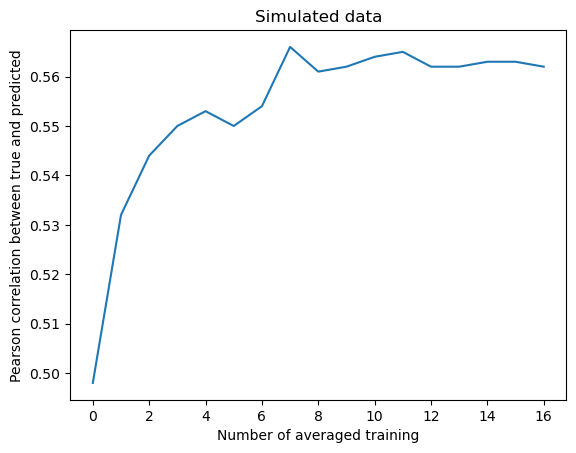

In [13]:
plt.plot(Pearsons)
plt.title("Simulated data")
plt.ylabel("Pearson correlation between true and predicted")
plt.xlabel("Number of averaged training")